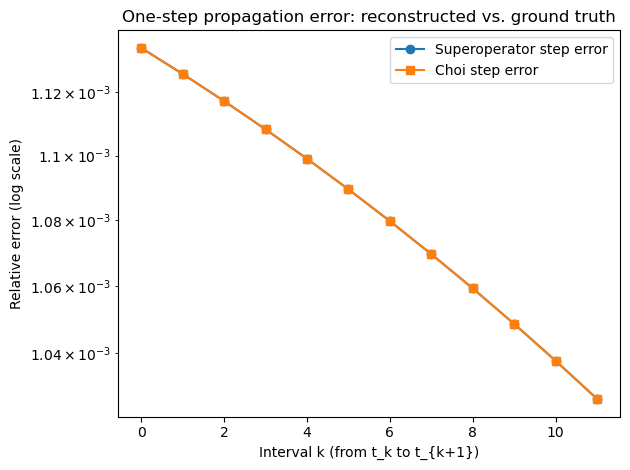

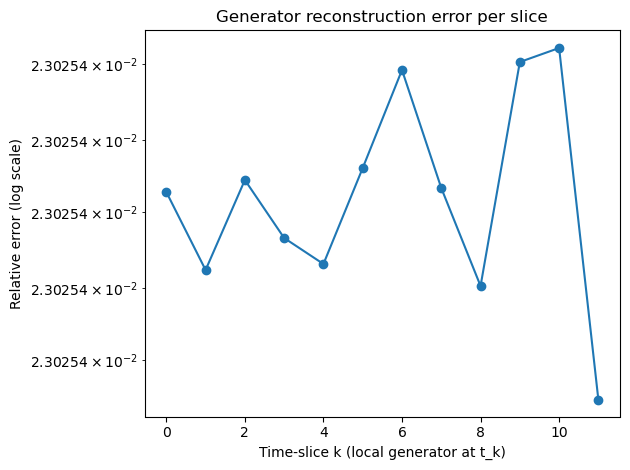

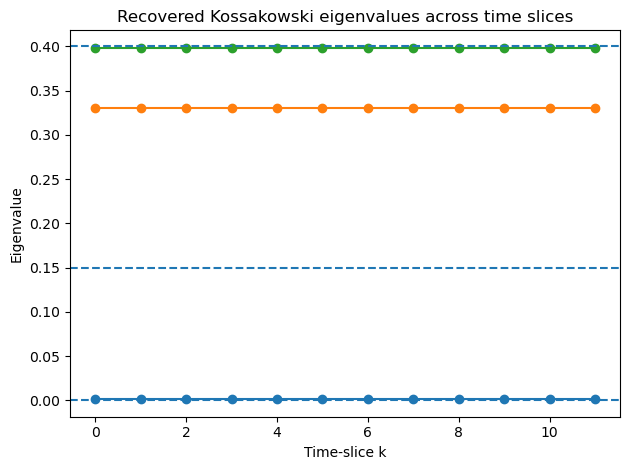

Mean step-propagation relative error (Super): 0.0010829132475473912
Mean step-propagation relative error (Choi) : 0.0010829132475473912
Mean generator relative error              : 0.023025414137499603


In [7]:
# End-to-end demo: reconstruct GKSL from Choi snapshots, then verify by propagation.
# Implementation uses only NumPy/SciPy + Matplotlib (no QuTiP dependency).

import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

# ---------- Linear algebra helpers ----------
def vec(X):
    return X.reshape((-1,1), order="F")

def mat(v, d):
    return v.reshape((d,d), order="F")

# Choi <-> Super reshuffling (d-by-d system)
def super_to_choi(S, d):
    J = np.zeros((d*d, d*d), dtype=complex)
    for a in range(d):
        for g in range(d):
            for b in range(d):
                for dl in range(d):
                    J[a*d + b, g*d + dl] = S[a*d + g, b*d + dl]
    return J

def choi_to_super(J, d):
    S = np.zeros((d*d, d*d), dtype=complex)
    for a in range(d):
        for g in range(d):
            for b in range(d):
                for dl in range(d):
                    S[a*d + g, b*d + dl] = J[a*d + b, g*d + dl]
    return S

# Hamiltonian and dissipator (Liouville) superoperators
def hamiltonian_super(H):
    d = H.shape[0]
    I = np.eye(d)
    return -1j * (np.kron(I, H) - np.kron(H.T, I))

def dissipator_super_from_jumps(jumps):
    d = jumps[0].shape[0]
    I = np.eye(d)
    Ld = np.zeros((d*d, d*d), dtype=complex)
    for L in jumps:
        Ld += np.kron(L, L.conj())  # term: L ⊗ L*
        M = L.conj().T @ L
        Ld -= 0.5 * (np.kron(I, M.T) + np.kron(M, I))
    return Ld

def expm_super(L, t):
    return la.expm(t * L)

# ---------- Reconstruction subroutines (no projection) ----------
def local_generator_from_choi_list(J_list, t_list):
    d = int(np.sqrt(J_list[0].shape[0]))
    S_list = [choi_to_super(J, d) for J in J_list]
    L_list = []
    for k in range(len(S_list)-1):
        dt = t_list[k+1] - t_list[k]
        dS = (S_list[k+1] - S_list[k]) / dt
        Sinv = la.inv(S_list[k])
        L_list.append(dS @ Sinv)
    return L_list, S_list

def build_Bmn_pauli():
    # Pauli basis Fm = σ_m / sqrt(2), m in {x,y,z}
    sx = np.array([[0,1],[1,0]], dtype=complex)
    sy = np.array([[0,-1j],[1j,0]], dtype=complex)
    sz = np.array([[1,0],[0,-1]], dtype=complex)
    F = [sx/np.sqrt(2), sy/np.sqrt(2), sz/np.sqrt(2)]
    B = []
    for m in range(3):
        for n in range(3):
            Fm = F[m]
            Fn = F[n]
            term1 = np.kron(Fm, Fn.conj())
            Mn = Fn.conj().T @ Fm
            term2 = 0.5*(np.kron(np.eye(2), Mn.T) + np.kron(Mn, np.eye(2)))
            B.append(term1 - term2)
    return F, B

def invert_C_from_Ld(Ld, B):
    B_mat = np.column_stack([b.reshape(-1) for b in B])  # 16 x 9
    L_vec = Ld.reshape(-1)
    C_vec, *_ = la.lstsq(B_mat, L_vec)  # pure linear inversion (no projection)
    return C_vec.reshape(3,3)

def diag_C_get_jumps(C, F):
    C_herm = 0.5*(C + C.conj().T)
    w, V = la.eigh(C_herm)
    L_ops = []
    for r, gamma in enumerate(w):
        if gamma < 0:
            # keep negative-eig diagnostic silent; skip negative tiny values
            continue
        coeffs = V[:, r]
        L = np.sqrt(gamma) * sum(c * Fm for c, Fm in zip(coeffs, F))
        L_ops.append(L)
    A = 0.5*sum(L.conj().T @ L for L in L_ops) if L_ops else np.zeros((2,2), dtype=complex)
    return L_ops, A, w

# ---------- Ground-truth model: H + jumps ----------
d = 2
# Hamiltonian H = 0.5*(ω σz + Ω σx)
ω, Ω = 1.2, 0.35
sx = np.array([[0,1],[1,0]], dtype=complex)
sz = np.array([[1,0],[0,-1]], dtype=complex)
H = 0.5*(ω*sz + Ω*sx)

# Jump operators: amplitude damping (σ-) + pure dephasing (σz)
σm = np.array([[0,0],[1,0]], dtype=complex)
γ_relax = 0.40
γ_deph  = 0.15
jumps_true = [np.sqrt(γ_relax)*σm, np.sqrt(γ_deph)*sz]

# Build true generator and sample channels
L_H_true = hamiltonian_super(H)
L_D_true = dissipator_super_from_jumps(jumps_true)
L_true   = L_H_true + L_D_true
t_list = np.linspace(0.0, 0.6, 13)  # 13 points -> 12 intervals
S_list_true = [expm_super(L_true, t) for t in t_list]
J_list = [super_to_choi(S, d) for S in S_list_true]

# ---------- Reconstruction from Choi snapshots ----------
L_list_loc, S_list_obs = local_generator_from_choi_list(J_list, t_list)
F_pauli, Bmn = build_Bmn_pauli()

# Diagnostics storage
gen_rel_errs = []
step_errs_super = []
step_errs_choi  = []
C_eigs_over_k   = []

for k, Lk in enumerate(L_list_loc):
    # Remove known Hamiltonian exactly
    L_D_hat = Lk - L_H_true
    C_hat   = invert_C_from_Ld(L_D_hat, Bmn)
    Lops, Ahat, evals = diag_C_get_jumps(C_hat, F_pauli)

    # Recovered dissipator & generator
    L_D_rec = dissipator_super_from_jumps(Lops) if Lops else np.zeros_like(L_D_true)
    L_rec   = L_H_true + L_D_rec

    # Generator relative error
    gen_err = la.norm(L_rec - L_true) / max(1e-12, la.norm(L_true))
    gen_rel_errs.append(gen_err)
    C_eigs_over_k.append(np.sort(evals.real))  # store sorted for a stable plot

    # Compare one-step propagation over next interval
    dt = t_list[k+1] - t_list[k]
    S_step_true = expm_super(L_true, dt)
    S_step_rec  = expm_super(L_rec,  dt)
    S_next_true = S_step_true @ S_list_obs[k]
    S_next_rec  = S_step_rec  @ S_list_obs[k]
    errS = la.norm(S_next_rec - S_next_true) / max(1e-12, la.norm(S_next_true))
    step_errs_super.append(errS)

    J_next_true = super_to_choi(S_next_true, d)
    J_next_rec  = super_to_choi(S_next_rec,  d)
    errJ = la.norm(J_next_rec - J_next_true) / max(1e-12, la.norm(J_next_true))
    step_errs_choi.append(errJ)

C_eigs_over_k = np.array(C_eigs_over_k)  # shape: (K, 3)

# ---------- Plot 1: Relative errors per interval (Super & Choi) ----------
plt.figure()
x = np.arange(len(step_errs_super))
plt.plot(x, step_errs_super, marker="o", label="Superoperator step error")
plt.plot(x, step_errs_choi,  marker="s", label="Choi step error")
plt.yscale("log")
plt.xlabel("Interval k (from t_k to t_{k+1})")
plt.ylabel("Relative error (log scale)")
plt.title("One-step propagation error: reconstructed vs. ground truth")
plt.legend()
plt.tight_layout()
plt.show()

# ---------- Plot 2: Generator relative error per interval ----------
plt.figure()
plt.plot(np.arange(len(gen_rel_errs)), gen_rel_errs, marker="o")
plt.yscale("log")
plt.xlabel("Time-slice k (local generator at t_k)")
plt.ylabel("Relative error (log scale)")
plt.title("Generator reconstruction error per slice")
plt.tight_layout()
plt.show()

# ---------- Plot 3: Recovered Kossakowski eigenvalues per slice ----------
# Ground-truth C eigenvalues for reference: amplitude damping + dephasing -> nonzero ~ [γ_deph, γ_relax], one ~ 0
true_eigs_sorted = np.sort(np.array([γ_deph, γ_relax, 0.0]))
plt.figure()
for i in range(3):
    plt.plot(np.arange(len(C_eigs_over_k)), C_eigs_over_k[:, i], marker="o", label=f"eig {i+1}")
# plot truth as horizontal lines
for val in true_eigs_sorted:
    plt.axhline(val, linestyle="--")
plt.xlabel("Time-slice k")
plt.ylabel("Eigenvalue")
plt.title("Recovered Kossakowski eigenvalues across time slices")
plt.tight_layout()
plt.show()

# Print summary stats
print("Mean step-propagation relative error (Super):", np.mean(step_errs_super))
print("Mean step-propagation relative error (Choi) :", np.mean(step_errs_choi))
print("Mean generator relative error              :", np.mean(gen_rel_errs))


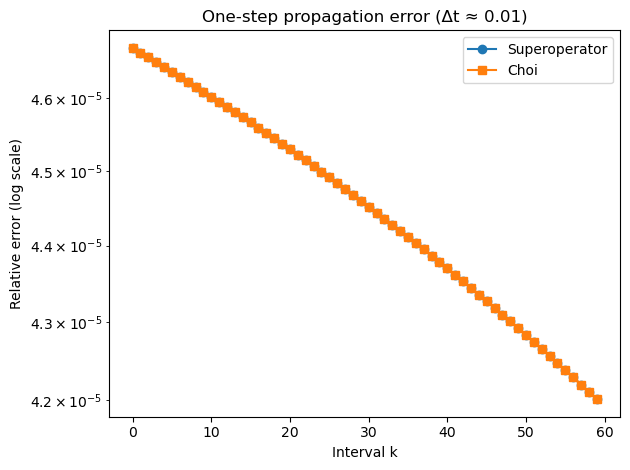

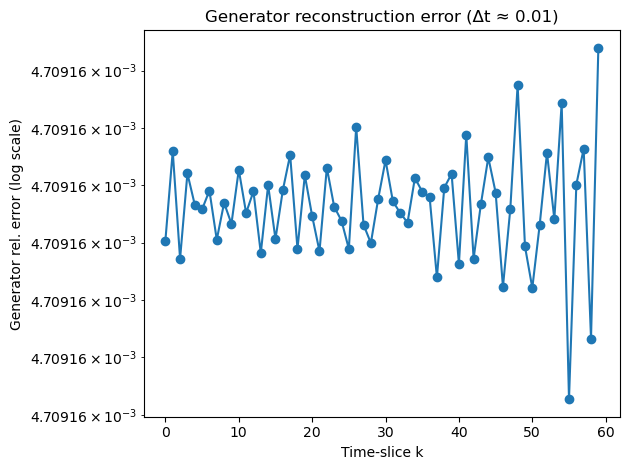

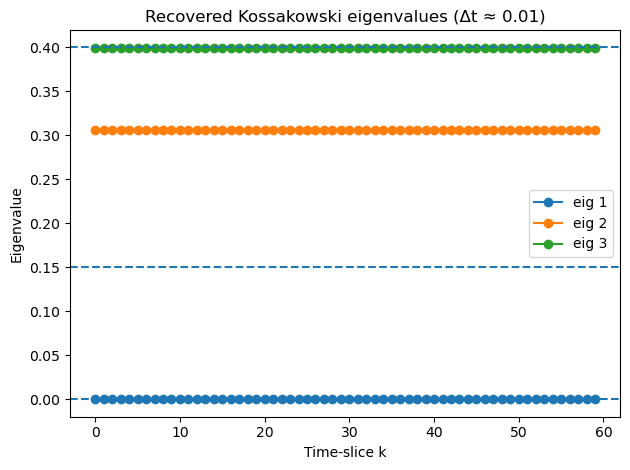

Mean step-propagation relative error (Super): 4.4489475714991956e-05
Mean step-propagation relative error (Choi) : 4.448947571499197e-05
Mean generator relative error              : 0.004709164147678186


In [8]:
# Repeat the same demonstration with smaller Δt (higher time resolution)
# to reduce finite-difference error and verify convergence of reconstruction accuracy.

t_list = np.linspace(0.0, 0.6, 61)  # 61 points -> 60 intervals (Δt ~ 0.01)
S_list_true = [expm_super(L_true, t) for t in t_list]
J_list = [super_to_choi(S, d) for S in S_list_true]

# Reconstruction with higher time resolution
L_list_loc, S_list_obs = local_generator_from_choi_list(J_list, t_list)
F_pauli, Bmn = build_Bmn_pauli()

gen_rel_errs = []
step_errs_super = []
step_errs_choi  = []
C_eigs_over_k   = []

for k, Lk in enumerate(L_list_loc):
    L_D_hat = Lk - L_H_true
    C_hat   = invert_C_from_Ld(L_D_hat, Bmn)
    Lops, Ahat, evals = diag_C_get_jumps(C_hat, F_pauli)

    L_D_rec = dissipator_super_from_jumps(Lops) if Lops else np.zeros_like(L_D_true)
    L_rec   = L_H_true + L_D_rec

    gen_err = la.norm(L_rec - L_true) / max(1e-12, la.norm(L_true))
    gen_rel_errs.append(gen_err)
    C_eigs_over_k.append(np.sort(evals.real))

    dt = t_list[k+1] - t_list[k]
    S_step_true = expm_super(L_true, dt)
    S_step_rec  = expm_super(L_rec,  dt)
    S_next_true = S_step_true @ S_list_obs[k]
    S_next_rec  = S_step_rec  @ S_list_obs[k]
    errS = la.norm(S_next_rec - S_next_true) / max(1e-12, la.norm(S_next_true))
    step_errs_super.append(errS)

    J_next_true = super_to_choi(S_next_true, d)
    J_next_rec  = super_to_choi(S_next_rec,  d)
    errJ = la.norm(J_next_rec - J_next_true) / max(1e-12, la.norm(J_next_true))
    step_errs_choi.append(errJ)

C_eigs_over_k = np.array(C_eigs_over_k)

# Plot results again
plt.figure()
plt.plot(step_errs_super, marker="o", label="Superoperator")
plt.plot(step_errs_choi, marker="s", label="Choi")
plt.yscale("log")
plt.xlabel("Interval k")
plt.ylabel("Relative error (log scale)")
plt.title("One-step propagation error (Δt ≈ 0.01)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
plt.plot(gen_rel_errs, marker="o")
plt.yscale("log")
plt.xlabel("Time-slice k")
plt.ylabel("Generator rel. error (log scale)")
plt.title("Generator reconstruction error (Δt ≈ 0.01)")
plt.tight_layout()
plt.show()

true_eigs_sorted = np.sort(np.array([γ_deph, γ_relax, 0.0]))
plt.figure()
for i in range(3):
    plt.plot(C_eigs_over_k[:, i], marker="o", label=f"eig {i+1}")
for val in true_eigs_sorted:
    plt.axhline(val, linestyle="--")
plt.xlabel("Time-slice k")
plt.ylabel("Eigenvalue")
plt.title("Recovered Kossakowski eigenvalues (Δt ≈ 0.01)")
plt.legend()
plt.tight_layout()
plt.show()

print("Mean step-propagation relative error (Super):", np.mean(step_errs_super))
print("Mean step-propagation relative error (Choi) :", np.mean(step_errs_choi))
print("Mean generator relative error              :", np.mean(gen_rel_errs))
